In [1]:
# %%
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import imageio
import time


In [2]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        53*53*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((53, 53, 256)))
    # New shape is (BATCH_SIZE, 53, 53, 256)

    model.add(tf.keras.layers.Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # New shape is (BATCH_SIZE, 53, 53, 128)
    assert model.output_shape == (None, 53, 53, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(
        64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # New shape is (BATCH_SIZE, 53, 53, 64)
    assert model.output_shape == (None, 53, 53, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(
        32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # New shape is (BATCH_SIZE, 53, 53, 32)
    assert model.output_shape == (None, 53, 53, 32)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(
        2, 2), padding='same', use_bias=False, activation='tanh'))
    # New shape is (BATCH_SIZE, 106, 106, 1)
    assert model.output_shape == (None, 106, 106, 1)

    return model


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[106, 106, 1]))
    assert model.output_shape == (None, 53, 53, 32)
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(
        64, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 53, 53, 64)
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(
        128, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 53, 53, 128)
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [3]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss)


def train(data):
    checkpoint_dir = 'gan_model/training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)
    
    try:
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        print("Successfully loaded previous checkpoint!")
    except:
        print("Could not load any checkpoints!")

    print("Starting training...")
    for epoch in range(EPOCHS):
        start = time.time()
        
        gen_loss, disc_loss = 0, 0
        count = 0
        for image_batch in data:
            gl, dl = train_step(image_batch)
            gen_loss += gl
            disc_loss += dl
            count += 1

        # Save the model every 5 epochs
        # if (epoch + 1) % 10 == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec. Loss: ({}, {})'.format(
            epoch + 1, time.time()-start, gen_loss / count, disc_loss / count))

    
    checkpoint.save(file_prefix=checkpoint_prefix)
    # Generate after the final epoch

def load_data(folder):
    images = []
    for im_path in glob.glob(folder + "/*.png"):
        images.append(imageio.imread(im_path))
    return np.asarray(images)

In [4]:
generator = make_generator()
discriminator = make_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
IMG_HEIGHT = 106
IMG_WIDTH = 106
BUFFER_SIZE = 10000
BATCH_SIZE = 256
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [5]:
train_images = load_data("data")
train_images = train_images.reshape(train_images.shape[0], 106, 106, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [7]:
train(train_dataset)

Successfully loaded previous checkpoint!
Starting training...
Time for epoch 1 is 8.235119342803955 sec. Loss: (2.1475000381469727, 0.4641382694244385)
Time for epoch 2 is 8.213549137115479 sec. Loss: (2.2945470809936523, 0.33001983165740967)
Time for epoch 3 is 8.21564793586731 sec. Loss: (2.4296798706054688, 0.29961949586868286)
Time for epoch 4 is 8.216439008712769 sec. Loss: (2.4746367931365967, 0.3177529275417328)
Time for epoch 5 is 8.214885473251343 sec. Loss: (2.522695779800415, 0.363054484128952)
Time for epoch 6 is 8.198839902877808 sec. Loss: (2.536451816558838, 0.4463382959365845)
Time for epoch 7 is 8.240164756774902 sec. Loss: (2.5825109481811523, 0.5706188082695007)
Time for epoch 8 is 8.210354328155518 sec. Loss: (2.519848108291626, 0.8346023559570312)
Time for epoch 9 is 8.206687688827515 sec. Loss: (2.1398427486419678, 0.4456852078437805)
Time for epoch 10 is 8.20442795753479 sec. Loss: (2.213740348815918, 0.390074223279953)
Time for epoch 11 is 8.203599691390991 sec.

KeyboardInterrupt: 

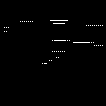

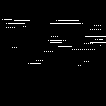

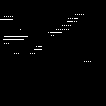

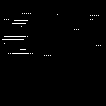

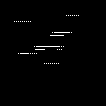

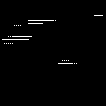

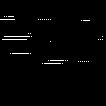

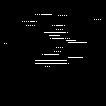

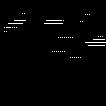

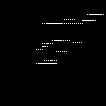

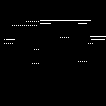

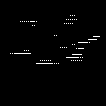

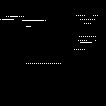

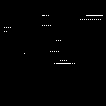

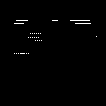

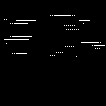

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [29]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

def showarray(a, fmt='png'):
    a = np.uint8(a*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

def savearray(a, path, fmt='png'):
    a = np.uint8(a*255)
    PIL.Image.fromarray(a).save(path, fmt)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        fig = plt.figure()
        # plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0].numpy() > 0.25390625).astype("float")
        showarray(pred)
        savearray(pred, 'image_{:04d}.png'.format(i))
        
        # fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
        # fig.figimage((predictions[i, :, :, 0].numpy() > 0.25390625).astype("float"), cmap='gray')
        # plt.imshow(predictions[i, :, :, 0], cmap='gray')
        # plt.axis('off')
        # plt.savefig('image_{:04d}.png'.format(i), bbox_inches='tight',transparent=True, pad_inches=0)
    
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, EPOCHS, seed)